### Initialization ###

In [32]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import signal
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import models.ids_models as models
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from data_processing import data_loading
import copy
pd.options.mode.chained_assignment = None

%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 10, 5

# Training hyperparameters
sensor_id = 1
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 1
learning_rate = 0.0001
num_epochs = 150
seq_len = 50
n_features = 1

### Load the data

In [33]:
df_ori = pd.read_csv('Datasets/OriginalData.csv')[['sensor1', 'sensor2']]
df_gen = pd.read_csv('Datasets/GeneratedData.csv')[['sensor1', 'sensor2']]

scaler1 = MinMaxScaler().fit(pd.DataFrame(df_ori['sensor1']).values)
scaler2 = MinMaxScaler().fit(pd.DataFrame(df_ori['sensor2']).values)

s1_ori = data_loading(pd.DataFrame(df_ori['sensor1']).values, seq_len, scaler1, True)
s1_ori = np.array(s1_ori)
s2_ori = data_loading(pd.DataFrame(df_ori['sensor2']).values, seq_len, scaler2, True)
s2_ori = np.array(s2_ori)
s1_gen = data_loading(pd.DataFrame(df_gen['sensor1']).values, seq_len, scaler1, True)
s1_gen = np.array(s1_gen)
s2_gen = data_loading(pd.DataFrame(df_gen['sensor2']).values, seq_len, scaler2, True)
s2_gen = np.array(s2_gen)

ori_data = s1_ori if sensor_id == 1 else s2_ori
gen_data = s1_gen if sensor_id == 1 else s2_gen
scaler = scaler1 if sensor_id == 1 else scaler2
df_original = pd.DataFrame(df_ori['sensor%i' % (sensor_id)])
df_generated = pd.DataFrame(df_gen['sensor%i' % (sensor_id)])

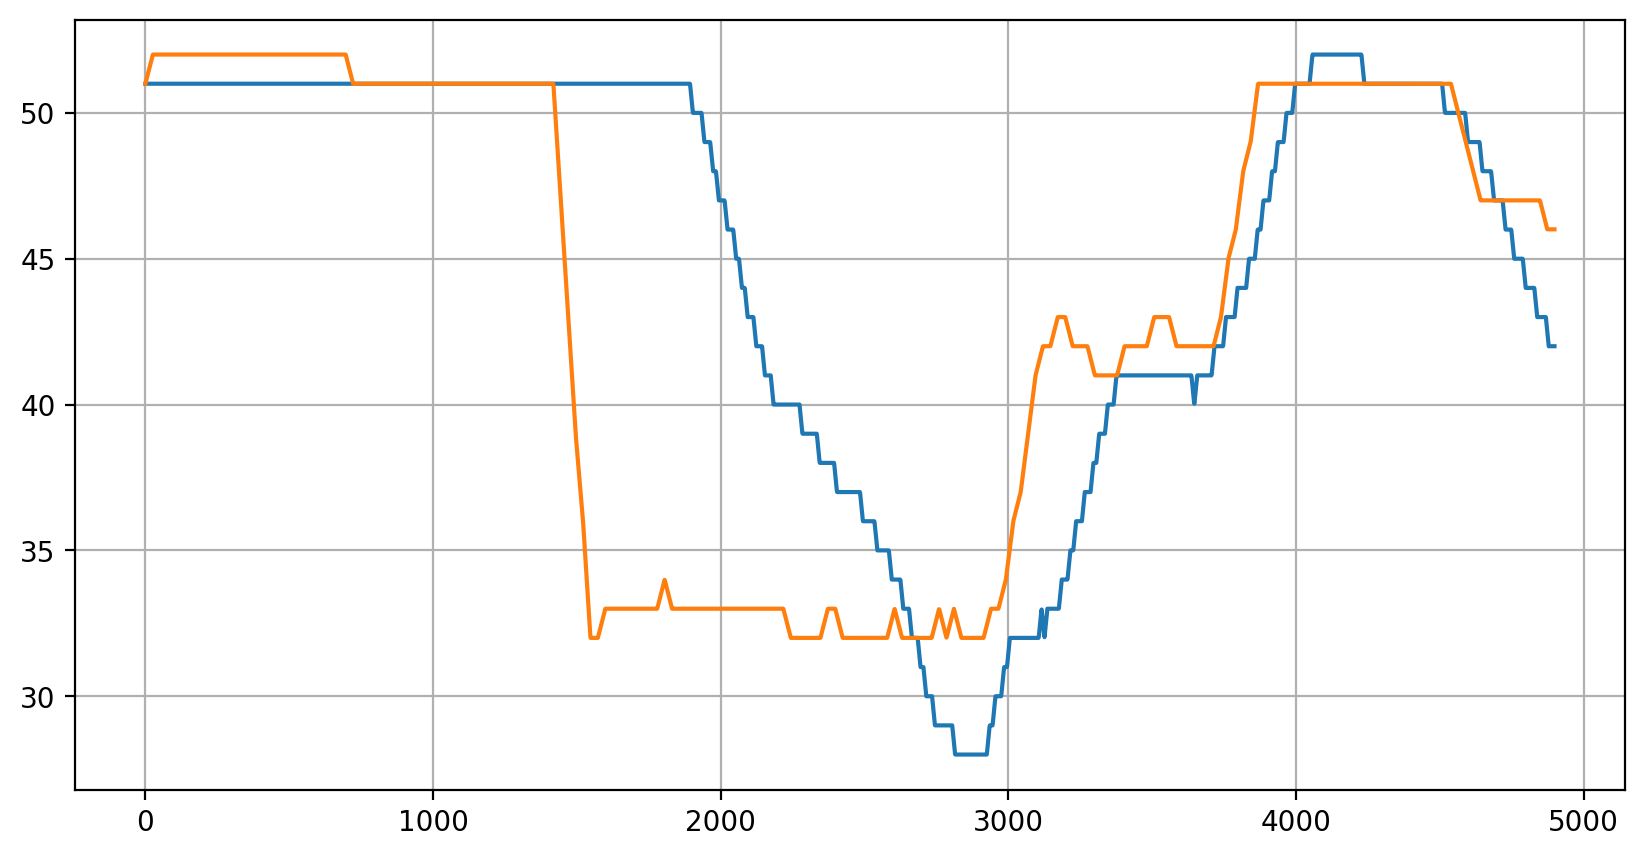

In [34]:
s, e = None, None
plt.plot(df_original[s:e])
plt.plot(df_generated[s:e])
plt.grid(True)

### Simualte Attacks

In [35]:
# Create array of attack indxes and corresponding labels to compute accuracy later (0 = normal data, 1 = anomalous data)
data_length = len(df_original)
mv = True
att_len = 130
att_instances = 17
non_att_len = 300
i_list = []
for i in range(att_instances): # number of attacks you want to inject
     sind = i*non_att_len + seq_len
     interval = (sind, sind+att_len)
     i_list.append(interval)
affected_indexes = np.array([])
ground_truth_labels = np.zeros(data_length - seq_len, dtype=int)
for interval in i_list:
    affected_indexes = np.concatenate((affected_indexes, np.arange(interval[0], interval[1], dtype=int)))
    ground_truth_labels[interval[0] - seq_len + 5: interval[1] -5] = 1

# GAN attack Data
gen_att = copy.deepcopy(df_generated.values)
for i in range(data_length):
    if i not in affected_indexes:
           gen_att[i] = df_original['sensor%i' % (sensor_id)][i]
df_gen_att = pd.DataFrame(gen_att)
gen_att_data = data_loading(df_gen_att.values, seq_len, scaler, moving_window=mv)
gen_att_data = np.array(gen_att_data)

# Random attack data
random = np.random.uniform(low=20.0, high=80.0, size=(data_length,))
for i in range(data_length):
    if i not in affected_indexes:
            random[i] = df_original['sensor%i' % (sensor_id)][i]         
df_ran = pd.DataFrame(random)
df_ran.rename(columns={0: 'sensor%i' % (sensor_id)}, inplace=True)
ran_data = data_loading(df_ran.values, seq_len, scaler, moving_window=mv)
ran_data = np.array(ran_data)

# Sawtooth attack data
t = np.linspace(0, data_length, data_length)
sawtooth = signal.sawtooth(2 * np.pi * 50 * t)
sawtooth = (sawtooth*30) + 50
for i in range(data_length):
    if i not in affected_indexes:
            sawtooth[i] = df_original['sensor%i' % (sensor_id)][i]
df_saw = pd.DataFrame(sawtooth)
df_saw.rename(columns={0: 'sensor%i' % (sensor_id)}, inplace=True)
saw_data = data_loading(df_saw.values, seq_len, scaler, moving_window=mv)
saw_data = np.array(saw_data)

# Plateau attack data
plat_value = max(df_original.values)*0.95 #min(df_ori.values) + (max(df_ori.values) - min(df_ori.values))/2
plateau = np.full((data_length,), plat_value)
for i in range(data_length):
    if i not in affected_indexes:
        plateau[i] = df_original['sensor%i' % (sensor_id)][i]
df_plat = pd.DataFrame(plateau)
plat_data = data_loading(df_plat.values, seq_len, scaler, moving_window=mv)
plat_data = np.array(plat_data)    
               
# Replay attack data
replay_sequence = copy.deepcopy(df_original[2000:2800].values)
replay = copy.deepcopy(df_original.values) 
for i in range(data_length):
    if i in affected_indexes:
        if i in np.array(i_list)[:,0]:
             offset = i
        replay[i] = replay_sequence[i - offset]
df_rep = pd.DataFrame(replay)
rep_data = data_loading(df_rep.values, seq_len, scaler, moving_window=mv)
rep_data = np.array(rep_data) 


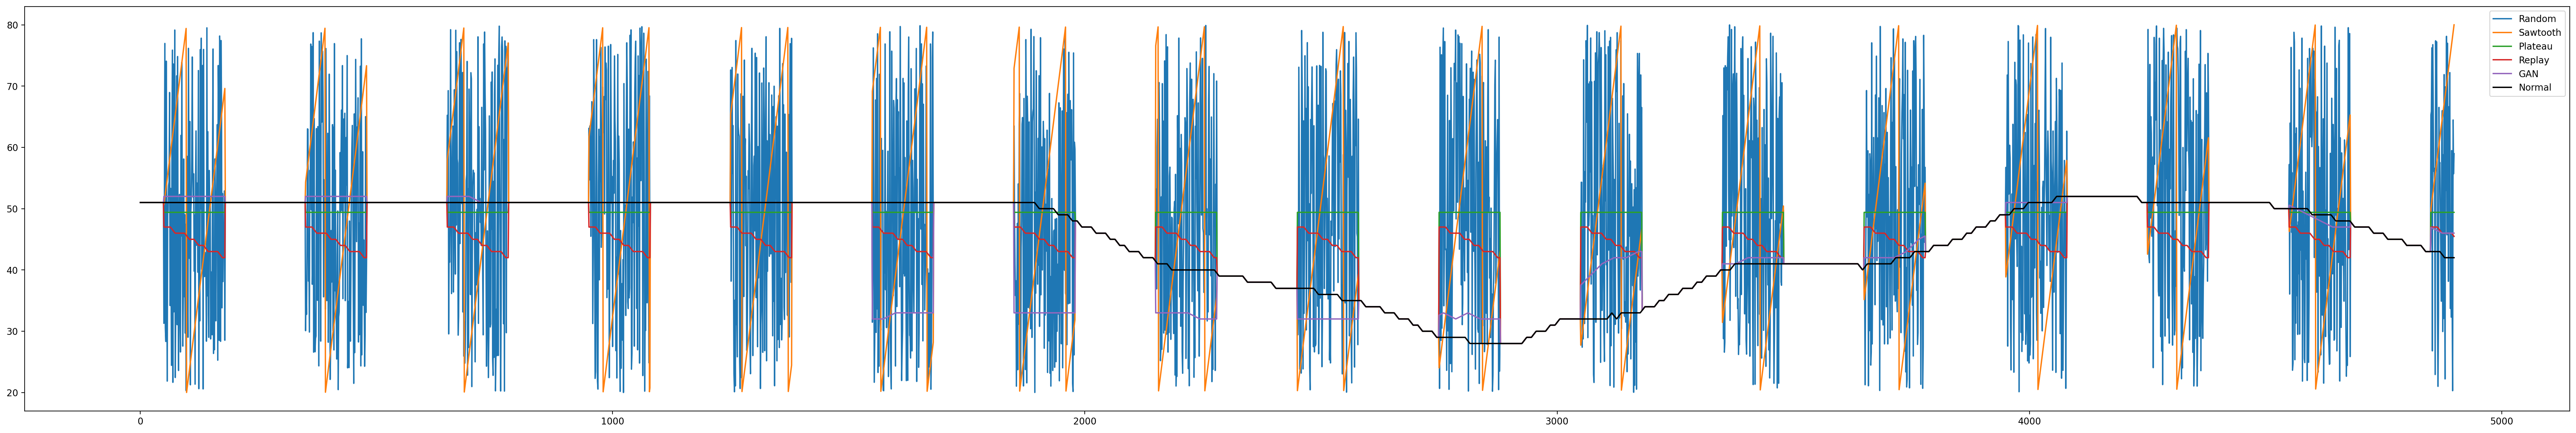

In [37]:
plt.figure(figsize=(50, 8))

plt.plot(df_ran, label = 'Random' )
plt.plot(df_saw, label = 'Sawtooth')
plt.plot(df_plat, label = 'Plateau')
plt.plot(df_rep, label = 'Replay')
plt.plot(df_gen_att, label = 'GAN')
plt.plot(df_original, label = 'Normal', color = 'black' )

plt.legend()

In [43]:
# Create datasets and data loaders
class AutoencoderDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()    

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

split_index = len(ori_data)

original_dataset = AutoencoderDataset(ori_data)
gen_dataset = AutoencoderDataset(gen_data)
ran_dataset = AutoencoderDataset(ran_data)
saw_dataset = AutoencoderDataset(saw_data)
gen_att_dataset = AutoencoderDataset(gen_att_data)
plat_dataset = AutoencoderDataset(plat_data)
replay_dataset = AutoencoderDataset(rep_data)

original_loader = DataLoader(original_dataset, batch_size=batch_size, shuffle=False)
gen_loader = DataLoader(gen_dataset, batch_size=batch_size, shuffle=False)
gen_att_loader = DataLoader(gen_att_dataset, batch_size=batch_size, shuffle=False)
ran_loader = DataLoader(ran_dataset, batch_size=batch_size, shuffle=False)
saw_loader = DataLoader(saw_dataset, batch_size=batch_size, shuffle=False)
plat_loader = DataLoader(plat_dataset, batch_size=batch_size, shuffle=False)
rep_loader = DataLoader(replay_dataset, batch_size=batch_size, shuffle=False)

### Model creation & training

In [44]:
# Instantaite the model and select loss criterion

model = models.INDRA_IDS_L(seq_len, n_features, device, 64)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction='mean').to(device)
history = dict(train=[], val=[])

In [45]:
# Load the model (load sensor 1 or 2 dependin on which one you are using)
model.load_state_dict( torch.load('sensor%i.pth' % (sensor_id)))

<All keys matched successfully>

### IDS Testing: Anomaly Detection 

In [51]:
# Visualize loss values over training set

predictions, losses = [], []
#criterion = nn.L1Loss(reduction='sum').to(device)
with torch.no_grad():
    model = model.eval()
    for seq in original_loader:
        seq = seq.to(device)
        seq_pred = model(seq)

        loss = criterion(seq_pred, seq)

        predictions.append(seq_pred.cpu().numpy().flatten())
        losses.append(loss.item())

THRESHOLD = max(losses) + 0.2*max(losses)
print('Anomaly Threshold set to %f' % THRESHOLD) 

Anomaly Threshold set to 0.000262


In [52]:
# Select which data to perform detection on
loader_selection = 3
loader = None
match loader_selection:
    case 1: 
        loader = original_loader
        df = copy.deepcopy(df_original)[int(seq_len/2):int(data_length-(seq_len/2))]
    case 2:
        loader = gen_loader
        df = copy.deepcopy(df_gen)[int(seq_len/2):int(data_length-(seq_len/2))]
    case 3:
        loader = gen_att_loader
        df = copy.deepcopy(df_gen_att)[int(seq_len/2):int(data_length-(seq_len/2))]
    case 4:
        loader = saw_loader
        df = copy.deepcopy(df_saw)[int(seq_len/2):int(data_length-(seq_len/2))]
    case 5:
        loader = ran_loader  
        df = copy.deepcopy(df_ran)[int(seq_len/2):int(data_length-(seq_len/2))] 
    case 6:
        loader = plat_loader
        df = copy.deepcopy(df_plat)[int(seq_len/2):int(data_length-(seq_len/2))]
    case 7:
        loader = rep_loader
        df = copy.deepcopy(df_rep)[int(seq_len/2):int(data_length-(seq_len/2))]

# Perform detection
with torch.no_grad():
    test_data_detections = []
    model = model.eval()
    for seq in loader:
        seq = seq.to(device)
        seq_pred = model(seq)
        loss = criterion(seq_pred, seq)
        if loss < THRESHOLD:
            test_data_detections.append(0)
        else:
            test_data_detections.append(1)
    
print("Anomalies detected in data: %i/%i" % (test_data_detections.count(1), len(test_data_detections)))

detection_labels = np.array(test_data_detections)

Anomalies detected in data: 775/4850


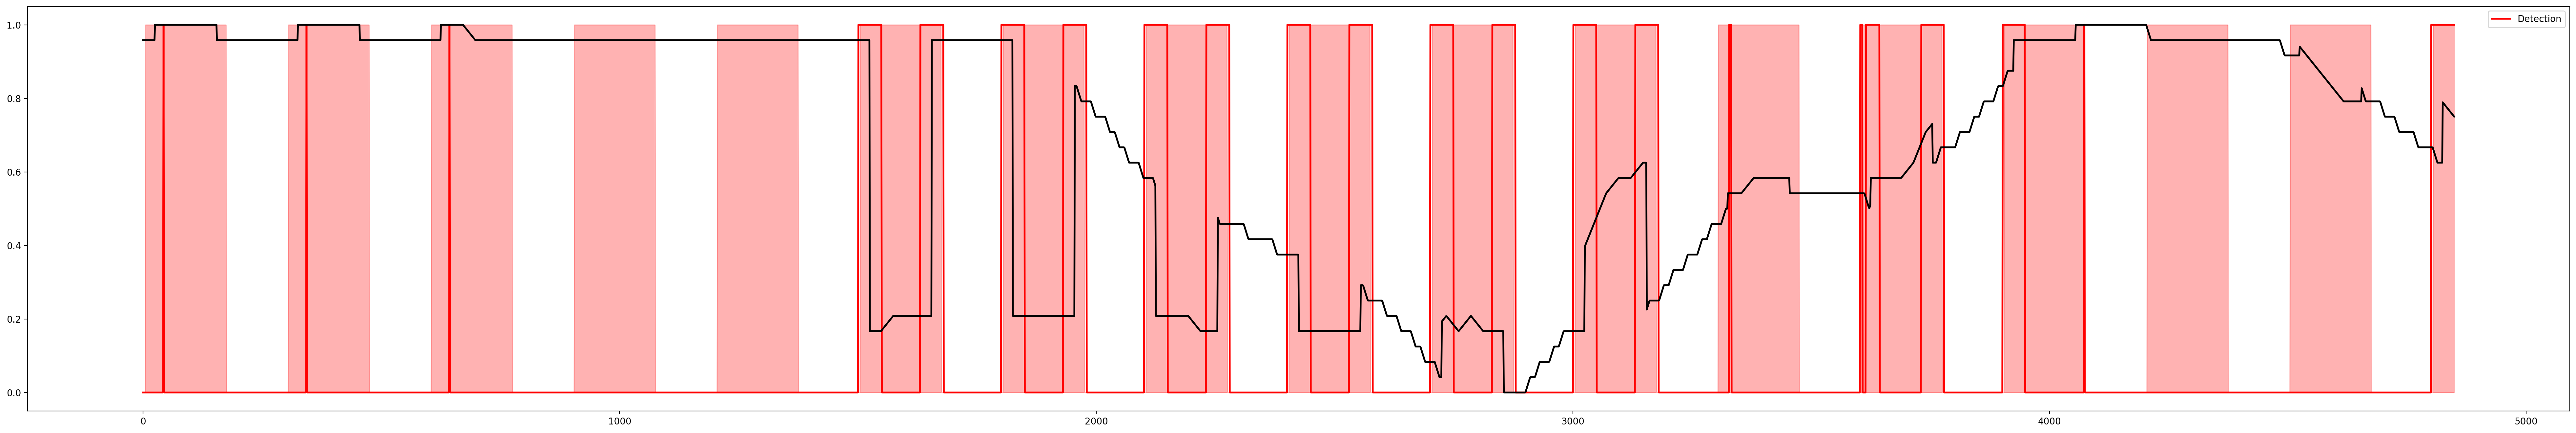

In [53]:
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
plt.figure(figsize=(50, 8))
plt.fill_between(np.arange(0, 4850), ground_truth_labels, color = 'red', alpha = 0.3)
plt.plot(detection_labels, label = 'Detection', color = 'red', linewidth = 2)
plt.plot((df-df.min())/(df.max()-df.min()), color = 'black', linewidth = 2)
plt.legend()